In [1]:
# -*- encoding:urf-8 -*-
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table like and matrices
import pandas as pd
import numpy as np

# Modeling Helper
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualization
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8,6

poi_path = '../../UAI_data/input/poi_re.csv'
train_Aug_path = '../../UAI_data/input/train_Aug_re.csv'
train_Jul_path = '../../UAI_data/input/train_July_re.csv'
train_jul_demand_path = '../../UAI_data/input/tain_jul_demand.csv'
train_aug_demand_path = '../../UAI_data/input/tain_aug_demand.csv'
location_path = '../../UAI_data/input/location_cls.csv'
holiday_path = '../../UAI_data/input/holiday.csv'
weather_path = '../../UAI_data/input/weather.csv'
test_path = '../../UAI_data/input/test.csv'

poi = pd.read_csv(poi_path,encoding='gbk')
train_aug = pd.read_csv(train_Aug_path,encoding='gbk')
train_jul = pd.read_csv(train_Jul_path,encoding='gbk')
train_jul_demand = pd.read_csv(train_jul_demand_path,encoding='gbk')
train_aug_demand = pd.read_csv(train_aug_demand_path,encoding='gbk')
loc_cls = pd.read_csv(location_path)
holiday = pd.read_csv(holiday_path)
weather = pd.read_csv(weather_path)
test = pd.read_csv(test_path,encoding='gbk')

### Helper Functions

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [3]:
coord = train_jul.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_money'].agg({'estimate_money_mean':'mean'})
coord

,create_date,create_hour,start_geo_id,end_geo_id,estimate_money_mean
0,2017-07-01,0,0,10,101.000000
1,2017-07-01,0,0,21,39.000000
2,2017-07-01,0,0,64,78.860000
3,2017-07-01,0,1,1,28.500000
4,2017-07-01,0,1,15,67.000000
5,2017-07-01,0,1,37,63.000000
6,2017-07-01,0,1,39,67.110000
7,2017-07-01,0,1,89,59.675000
8,2017-07-01,0,1,95,90.000000
9,2017-07-01,0,1,160,46.520000


In [4]:
train_jul_demand

,create_date,create_hour,start_geo_id,end_geo_id,demand_count
0,2017-07-01,0,0,10,1
1,2017-07-01,0,0,21,1
2,2017-07-01,0,0,64,1
3,2017-07-01,0,1,1,2
4,2017-07-01,0,1,15,2
5,2017-07-01,0,1,37,1
6,2017-07-01,0,1,39,2
7,2017-07-01,0,1,89,2
8,2017-07-01,0,1,95,1
9,2017-07-01,0,1,160,2


In [5]:
train_jul_exc = train_jul[train_jul['driver_id'] != 2].copy()
coord_jul = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['start_geo_id'].agg({'demand_count':'count'})
coord_jul.loc[:,'estimate_money_mean'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_money'].mean()['estimate_money']
coord_jul.loc[:,'estimate_money_median'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_money'].median()['estimate_money']
# coord_jul.loc[:,'estimate_money_std'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_money'].std()['estimate_money']
coord_jul.loc[:,'estimate_money_max'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_money'].max()['estimate_money']
coord_jul.loc[:,'estimate_money_min'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_money'].min()['estimate_money']
coord_jul.loc[:,'estimate_distance_mean'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_distance'].mean()['estimate_distance']
coord_jul.loc[:,'estimate_distance_median'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_distance'].median()['estimate_distance']
# coord_jul.loc[:,'estimate_distance_std'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_distance'].std()['estimate_distance']
coord_jul.loc[:,'estimate_distance_max'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_distance'].max()['estimate_distance']
coord_jul.loc[:,'estimate_distance_min'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_distance'].min()['estimate_distance']
coord_jul.loc[:,'estimate_term_mean'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_term'].mean()['estimate_term']
coord_jul.loc[:,'estimate_term_median'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_term'].median()['estimate_term']
# coord_jul.loc[:,'estimate_term_std'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_term'].std()['estimate_term']
coord_jul.loc[:,'estimate_term_max'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_term'].max()['estimate_term']
coord_jul.loc[:,'estimate_term_min'] = train_jul_exc.groupby(['create_date','create_hour','start_geo_id','end_geo_id'],as_index=False)['estimate_term'].min()['estimate_term']

coord_jul

,create_date,create_hour,start_geo_id,end_geo_id,demand_count,estimate_money_mean,estimate_money_median,estimate_money_max,estimate_money_min,estimate_distance_mean,estimate_distance_median,estimate_distance_max,estimate_distance_min,estimate_term_mean,estimate_term_median,estimate_term_max,estimate_term_min
0,2017-07-01,0,0,10,1,101.000,101.000,101.00,101.00,14431.0,14431.0,14431.0,14431.0,24.0,24.0,24.0,24.0
1,2017-07-01,0,0,21,1,39.000,39.000,39.00,39.00,4905.0,4905.0,4905.0,4905.0,9.0,9.0,9.0,9.0
2,2017-07-01,0,1,1,2,28.500,28.500,32.00,25.00,2437.0,2437.0,3220.0,1654.0,4.5,4.5,6.0,3.0
3,2017-07-01,0,1,15,2,67.000,67.000,73.00,61.00,10955.0,10955.0,12254.0,9656.0,21.5,21.5,24.0,19.0
4,2017-07-01,0,1,37,1,63.000,63.000,63.00,63.00,10010.0,10010.0,10010.0,10010.0,20.0,20.0,20.0,20.0
5,2017-07-01,0,1,39,2,67.110,67.110,67.41,66.81,11493.0,11493.0,11493.0,11493.0,17.5,17.5,18.0,17.0
6,2017-07-01,0,1,89,1,58.000,58.000,58.00,58.00,8905.0,8905.0,8905.0,8905.0,17.0,17.0,17.0,17.0
7,2017-07-01,0,1,95,1,90.000,90.000,90.00,90.00,15677.0,15677.0,15677.0,15677.0,31.0,31.0,31.0,31.0
8,2017-07-01,0,1,160,2,46.520,46.520,46.87,46.17,6347.0,6347.0,6453.0,6241.0,12.0,12.0,12.0,12.0
9,2017-07-01,0,1,303,1,66.000,66.000,66.00,66.00,11493.0,11493.0,11493.0,11493.0,17.0,17.0,17.0,17.0


#### holiday

In [6]:
holiday['create_date'] = pd.to_datetime(holiday['create_date'])
coord_jul['create_date'] = pd.to_datetime(coord_jul['create_date'])
coord_jul = pd.merge(coord_jul,holiday,on='create_date',how='left')
coord_jul

,create_date,create_hour,start_geo_id,end_geo_id,demand_count,estimate_money_mean,estimate_money_median,estimate_money_max,estimate_money_min,estimate_distance_mean,estimate_distance_median,estimate_distance_max,estimate_distance_min,estimate_term_mean,estimate_term_median,estimate_term_max,estimate_term_min,holiday
0,2017-07-01,0,0,10,1,101.000,101.000,101.00,101.00,14431.0,14431.0,14431.0,14431.0,24.0,24.0,24.0,24.0,1
1,2017-07-01,0,0,21,1,39.000,39.000,39.00,39.00,4905.0,4905.0,4905.0,4905.0,9.0,9.0,9.0,9.0,1
2,2017-07-01,0,1,1,2,28.500,28.500,32.00,25.00,2437.0,2437.0,3220.0,1654.0,4.5,4.5,6.0,3.0,1
3,2017-07-01,0,1,15,2,67.000,67.000,73.00,61.00,10955.0,10955.0,12254.0,9656.0,21.5,21.5,24.0,19.0,1
4,2017-07-01,0,1,37,1,63.000,63.000,63.00,63.00,10010.0,10010.0,10010.0,10010.0,20.0,20.0,20.0,20.0,1
5,2017-07-01,0,1,39,2,67.110,67.110,67.41,66.81,11493.0,11493.0,11493.0,11493.0,17.5,17.5,18.0,17.0,1
6,2017-07-01,0,1,89,1,58.000,58.000,58.00,58.00,8905.0,8905.0,8905.0,8905.0,17.0,17.0,17.0,17.0,1
7,2017-07-01,0,1,95,1,90.000,90.000,90.00,90.00,15677.0,15677.0,15677.0,15677.0,31.0,31.0,31.0,31.0,1
8,2017-07-01,0,1,160,2,46.520,46.520,46.87,46.17,6347.0,6347.0,6453.0,6241.0,12.0,12.0,12.0,12.0,1
9,2017-07-01,0,1,303,1,66.000,66.000,66.00,66.00,11493.0,11493.0,11493.0,11493.0,17.0,17.0,17.0,17.0,1


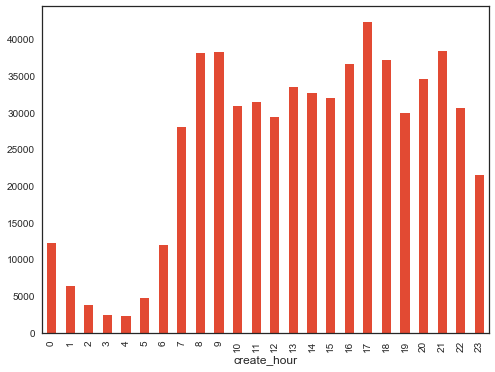

In [7]:
coord_jul.groupby('create_hour')['demand_count'].sum().plot(kind='bar')

In [8]:
loc_start = loc_cls.copy()
loc_start.rename(columns={'location_id':'start_geo_id','cluster':'start_cluster'},inplace=True)
coord_jul = pd.merge(coord_jul,loc_start,on='start_geo_id',how='left')
loc_end = loc_cls.copy()
loc_end.rename(columns={'location_id':'end_geo_id','cluster':'end_cluster'},inplace=True)
coord_jul = pd.merge(coord_jul,loc_end,on='end_geo_id',how='left')
coord_jul

,create_date,create_hour,start_geo_id,end_geo_id,demand_count,estimate_money_mean,estimate_money_median,estimate_money_max,estimate_money_min,estimate_distance_mean,estimate_distance_median,estimate_distance_max,estimate_distance_min,estimate_term_mean,estimate_term_median,estimate_term_max,estimate_term_min,holiday,start_cluster,end_cluster
0,2017-07-01,0,0,10,1,101.000,101.000,101.00,101.00,14431.0,14431.0,14431.0,14431.0,24.0,24.0,24.0,24.0,1,2,5
1,2017-07-01,0,0,21,1,39.000,39.000,39.00,39.00,4905.0,4905.0,4905.0,4905.0,9.0,9.0,9.0,9.0,1,2,1
2,2017-07-01,0,1,1,2,28.500,28.500,32.00,25.00,2437.0,2437.0,3220.0,1654.0,4.5,4.5,6.0,3.0,1,1,1
3,2017-07-01,0,1,15,2,67.000,67.000,73.00,61.00,10955.0,10955.0,12254.0,9656.0,21.5,21.5,24.0,19.0,1,1,1
4,2017-07-01,0,1,37,1,63.000,63.000,63.00,63.00,10010.0,10010.0,10010.0,10010.0,20.0,20.0,20.0,20.0,1,1,1
5,2017-07-01,0,1,39,2,67.110,67.110,67.41,66.81,11493.0,11493.0,11493.0,11493.0,17.5,17.5,18.0,17.0,1,1,1
6,2017-07-01,0,1,89,1,58.000,58.000,58.00,58.00,8905.0,8905.0,8905.0,8905.0,17.0,17.0,17.0,17.0,1,1,5
7,2017-07-01,0,1,95,1,90.000,90.000,90.00,90.00,15677.0,15677.0,15677.0,15677.0,31.0,31.0,31.0,31.0,1,1,3
8,2017-07-01,0,1,160,2,46.520,46.520,46.87,46.17,6347.0,6347.0,6453.0,6241.0,12.0,12.0,12.0,12.0,1,1,3
9,2017-07-01,0,1,303,1,66.000,66.000,66.00,66.00,11493.0,11493.0,11493.0,11493.0,17.0,17.0,17.0,17.0,1,1,3


In [9]:
coord_jul.loc[:,'weekOfDay'] = coord_jul['create_date'].dt.dayofweek
# coord_jul['weekOfDay'].unique()
coord_jul

,create_date,create_hour,start_geo_id,end_geo_id,demand_count,estimate_money_mean,estimate_money_median,estimate_money_max,estimate_money_min,estimate_distance_mean,...,estimate_distance_max,estimate_distance_min,estimate_term_mean,estimate_term_median,estimate_term_max,estimate_term_min,holiday,start_cluster,end_cluster,weekOfDay
0,2017-07-01,0,0,10,1,101.000,101.000,101.00,101.00,14431.0,...,14431.0,14431.0,24.0,24.0,24.0,24.0,1,2,5,5
1,2017-07-01,0,0,21,1,39.000,39.000,39.00,39.00,4905.0,...,4905.0,4905.0,9.0,9.0,9.0,9.0,1,2,1,5
2,2017-07-01,0,1,1,2,28.500,28.500,32.00,25.00,2437.0,...,3220.0,1654.0,4.5,4.5,6.0,3.0,1,1,1,5
3,2017-07-01,0,1,15,2,67.000,67.000,73.00,61.00,10955.0,...,12254.0,9656.0,21.5,21.5,24.0,19.0,1,1,1,5
4,2017-07-01,0,1,37,1,63.000,63.000,63.00,63.00,10010.0,...,10010.0,10010.0,20.0,20.0,20.0,20.0,1,1,1,5
5,2017-07-01,0,1,39,2,67.110,67.110,67.41,66.81,11493.0,...,11493.0,11493.0,17.5,17.5,18.0,17.0,1,1,1,5
6,2017-07-01,0,1,89,1,58.000,58.000,58.00,58.00,8905.0,...,8905.0,8905.0,17.0,17.0,17.0,17.0,1,1,5,5
7,2017-07-01,0,1,95,1,90.000,90.000,90.00,90.00,15677.0,...,15677.0,15677.0,31.0,31.0,31.0,31.0,1,1,3,5
8,2017-07-01,0,1,160,2,46.520,46.520,46.87,46.17,6347.0,...,6453.0,6241.0,12.0,12.0,12.0,12.0,1,1,3,5
9,2017-07-01,0,1,303,1,66.000,66.000,66.00,66.00,11493.0,...,11493.0,11493.0,17.0,17.0,17.0,17.0,1,1,3,5


In [10]:
coord_jul.groupby(['create_hour','start_geo_id','end_geo_id'])['estimate_money_mean'].mean()

create_hour  start_geo_id  end_geo_id
0            0             0               19.480000
                           8               52.000000
                           10             101.000000
                           13              77.000000
                           17              67.000000
                           21              39.000000
                           23              29.000000
                           31             151.000000
                           46             129.170000
                           60             179.330000
                           63              46.000000
                           71              72.000000
                           90             113.000000
                           115             63.000000
                           133             41.420000
                           187            215.000000
             1             0               82.000000
                           1               27.276364
        

In [11]:
test

,test_id,create_date,create_hour,start_geo_id_new,end_geo_id_new
0,0,2017-08-01,21,24,27
1,1,2017-08-01,21,24,9
2,2,2017-08-01,21,24,22
3,3,2017-08-01,17,24,9
4,4,2017-08-01,17,55,55
5,5,2017-08-01,17,110,88
6,6,2017-08-01,9,23,21
7,7,2017-08-01,21,16,50
8,8,2017-08-01,13,6,24
9,9,2017-08-01,21,6,22


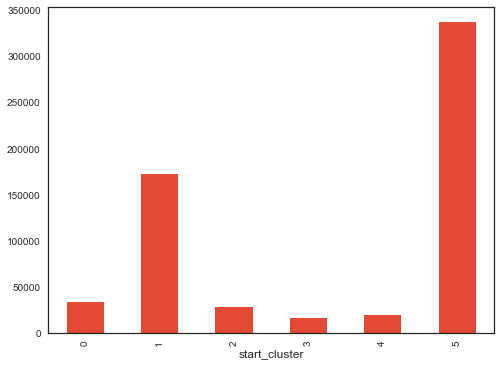

In [12]:
coord_jul.groupby('start_cluster')['demand_count'].sum().plot(kind='bar')

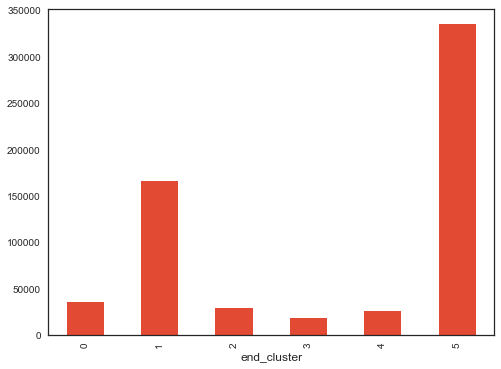

In [13]:
coord_jul.groupby('end_cluster')['demand_count'].sum().plot(kind='bar')

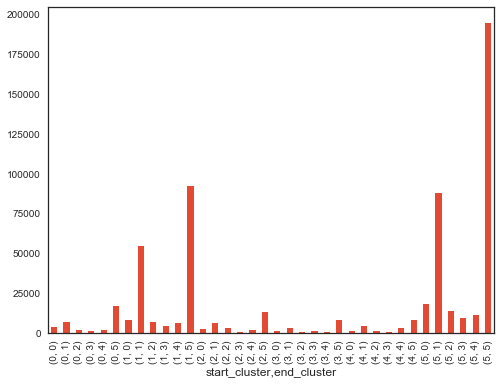

In [14]:
coord_jul.groupby(['start_cluster','end_cluster'])['demand_count'].sum().plot(kind='bar')